In [1]:

from google.colab import drive

drive.mount('/content/drive')

%cd drive/MyDrive/Colab Notebooks
#! ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('data_model.csv')
df.shape

(8712, 26)

In [3]:
df_trainA = df.sample(frac=0.7, random_state=44)
df_val_testA = df.drop(df_trainA.index).reset_index(drop=True)
df_valA = df_val_testA.sample(frac=0.5, random_state=44)
df_testA = df_val_testA.drop(df_valA.index).reset_index(drop=True)
df_trainA = df_trainA.reset_index(drop=True)
df_valA = df_valA.reset_index(drop=True)

print(df_trainA.shape, df_valA.shape, df_testA.shape)

(6098, 26) (1307, 26) (1307, 26)


In [4]:
df_train = df_trainA[['label', 'comment_text']]
df_val = df_valA[['label', 'comment_text']]
df_test = df_testA[['label', 'comment_text']]
df_train.head()

,label,comment_text
0,0,What would the expression be for the number of...
1,0,"So after i subtracted 11 from both sides, i go..."
2,0,you have to plug 3 in for x then solve the pro...
3,1,ok that was like a brain fart i should have kn...
4,0,"Well, since you are solving for x go ahead and..."


In [5]:
df_train.loc[3,:].comment_text

'ok that was like a brain fart i should have known that'

In [6]:
!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


In [7]:
#!pip install transformers

In [8]:
!pip install utils

# Load ELECTRA model and tokenizer


In [9]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from utils import *
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')

# Load Electra Model
model = AutoModelForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=2)

model.to(device)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

# Load Dataset

In [11]:
X_train_tokenized = tokenizer(list(df_train["comment_text"]), padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(list(df_val["comment_text"]), padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(list(df_test["comment_text"]), padding=True, truncation=True, max_length=512)

In [12]:
y_train = list(df_train["label"])
y_val = list(df_val["label"])
y_test = list(df_test["label"])

In [13]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [14]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized, y_test)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Fine-tuning

In [16]:
# Define the optimizer and learning rate scheduler
num_epochs = 5
#optimizer = optim.AdamW(model.parameters(), lr=6.68561343998775e-5, eps=1e-8)
#total_steps = len(train_loader) * num_epochs
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [18]:
from transformers import TrainingArguments, Trainer

In [19]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=20,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=num_epochs,
    seed=0,
    logging_steps=20,
    optim="adamw_torch",
    load_best_model_at_end=True,
)

In [20]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,

)

In [21]:
# import time

In [22]:
# Training Electra model
# train_loss = []
# val_losses = []
# val_accuracies = []

#start = time.time()
# trainer(train_loss, val_losses, val_accuracies, num_epochs, train_loader, val_dataset, val_loader, model, optimizer, scheduler, device)
# Train pre-trained model
# trainer.train()
#print("Time",time.time()-start)

In [23]:
# save the model
# torch.save(model.state_dict(), 'transformerELECTRA-1.pt')

#### Test model on test set

In [24]:
# Load trained model
# model_path = "output/checkpoint-2500"
# model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
#model.to(device)

In [25]:
# Define test trainer
# test_trainer = Trainer(model)

In [26]:
# Metrics for training dataset
# raw_pred_train, _, _ = test_trainer.predict(train_dataset)
# p_train = raw_pred_train, y_train
# metrics_train = compute_metrics(p_train)
# metrics_train

In [27]:
# Metrics for validation dataset
# raw_pred_val, _, _ = test_trainer.predict(val_dataset)
# p_val = raw_pred_val, y_val
# metrics_val = compute_metrics(p_val)
# metrics_val

In [28]:
# Metrics for test dataset
# Make prediction
# raw_pred_test, _, _ = test_trainer.predict(test_dataset)

# p_test = raw_pred_test, y_test
# metrics_test = compute_metrics(p_test)
# metrics_test

**SHAP**

In [29]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.9 MB/s eta 0:00:00


In [30]:
#from transformers import ZeroShotClassificationPipeline
from transformers import pipeline
from typing import Union, List
import shap

In [31]:
# Load trained model
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_path = "output/checkpoint-2500"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
#model.to(device)

In [32]:
# from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [33]:
pipe1 = pipeline("text-classification", model=model, tokenizer=tokenizer, top_k=None)

In [34]:
df_test['word_num'] = df_test.comment_text.fillna('').str.split(' ').apply(lambda x: len(x))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
df_test_filtered = df_test[
    df_test['word_num'] <= 350
]

In [36]:
df_test1 = df_test_filtered.sample(frac=0.1, random_state=44)

In [37]:
text_test = df_test1.comment_text
text_test.shape

(131,)

In [38]:
test_text = text_test.tolist()
#test_text

In [52]:
test_text[1]

'GUYS ANWSER THE GOD DAMN QUESTION ITS NOT THAT HARD m8y i h8y U'

In [39]:
pipe1(test_text[:5])


[[{'label': 'LABEL_1', 'score': 0.9997437596321106},
  {'label': 'LABEL_0', 'score': 0.0002562027657404542}],
 [{'label': 'LABEL_1', 'score': 0.9997450709342957},
  {'label': 'LABEL_0', 'score': 0.00025492062559351325}],
 [{'label': 'LABEL_0', 'score': 0.999940037727356},
  {'label': 'LABEL_1', 'score': 5.995484025334008e-05}],
 [{'label': 'LABEL_1', 'score': 0.9996377229690552},
  {'label': 'LABEL_0', 'score': 0.0003622379736043513}],
 [{'label': 'LABEL_0', 'score': 0.9999556541442871},
  {'label': 'LABEL_1', 'score': 4.4380842155078426e-05}]]

SHAP for explainability

In [40]:
# SHAP Explainer
explainer = shap.Explainer(pipe1)
shap_values = explainer(test_text)
#score_and_visualize(text, shap_values)

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:   1%|          | 1/131 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 3/131 [02:18<1:04:34, 30.27s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 4/131 [03:08<1:21:48, 38.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 5/131 [05:01<2:19:14, 66.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   5%|▍         | 6/131 [06:24<2:30:34, 72.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 7/131 [07:50<2:38:32, 76.71s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 8/131 [08:57<2:30:54, 73.62s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 9/131 [09:39<2:09:43, 63.80s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 10/131 [10:49<2:12:20, 65.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 11/131 [13:27<3:07:46, 93.89s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 12/131 [13:46<2:21:03, 71.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  10%|▉         | 13/131 [15:16<2:31:00, 76.78s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 14/131 [15:39<1:58:13, 60.63s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

Partition explainer:  11%|█▏        | 15/131 [16:38<1:55:53, 59.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 16/131 [18:25<2:22:09, 74.17s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 17/131 [19:38<2:20:14, 73.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  14%|█▎        | 18/131 [20:59<2:23:26, 76.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  15%|█▍        | 19/131 [22:44<2:38:21, 84.83s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 20/131 [23:59<2:31:17, 81.78s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 21/131 [24:33<2:03:41, 67.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 22/131 [27:00<2:45:39, 91.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 23/131 [28:22<2:39:28, 88.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 24/131 [29:55<2:40:25, 89.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 25/131 [31:49<2:51:39, 97.16s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:  20%|█▉        | 26/131 [33:02<2:37:09, 89.81s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 27/131 [33:48<2:12:43, 76.57s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

Partition explainer:  21%|██▏       | 28/131 [34:06<1:41:28, 59.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 29/131 [37:17<2:47:47, 98.70s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 30/131 [38:35<2:35:39, 92.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  24%|██▎       | 31/131 [39:58<2:29:28, 89.68s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 32/131 [41:07<2:17:48, 83.52s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 33/131 [42:24<2:13:03, 81.46s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 34/131 [43:15<1:57:06, 72.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 35/131 [44:43<2:02:57, 76.85s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 36/131 [45:23<1:44:20, 65.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 37/131 [46:58<1:57:13, 74.82s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 38/131 [47:54<1:46:51, 68.94s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  30%|██▉       | 39/131 [49:04<1:46:27, 69.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 40/131 [50:27<1:51:29, 73.51s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:  31%|███▏      | 41/131 [50:48<1:26:17, 57.53s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 42/131 [51:19<1:13:48, 49.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 43/131 [52:25<1:20:12, 54.69s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  34%|███▎      | 44/131 [53:10<1:15:05, 51.78s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 45/131 [53:34<1:01:59, 43.25s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 46/131 [54:48<1:14:32, 52.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 47/131 [57:52<2:08:41, 91.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 48/131 [59:20<2:05:30, 90.73s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 49/131 [59:32<1:31:55, 67.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 50/131 [1:01:43<1:56:27, 86.26s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 51/131 [1:02:32<1:40:10, 75.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|███▉      | 52/131 [1:04:30<1:55:52, 88.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 53/131 [1:05:53<1:52:22, 86.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 54/131 [1:07:10<1:47:29, 83.77s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 55/131 [1:08:21<1:41:08, 79.85s/it]

  0%|          | 0/90 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 56/131 [1:08:30<1:13:14, 58.59s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer:  44%|████▎     | 57/131 [1:09:21<1:09:35, 56.42s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 58/131 [1:09:45<56:48, 46.70s/it]  

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 59/131 [1:10:43<1:00:05, 50.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 60/131 [1:12:21<1:16:13, 64.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 61/131 [1:14:06<1:29:09, 76.42s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 62/131 [1:14:33<1:10:59, 61.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 63/131 [1:16:21<1:25:27, 75.41s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 64/131 [1:17:28<1:21:33, 73.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|████▉     | 65/131 [1:19:00<1:26:44, 78.86s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 66/131 [1:20:17<1:24:48, 78.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 67/131 [1:21:18<1:17:50, 72.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 68/131 [1:22:46<1:21:16, 77.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 69/131 [1:26:12<1:59:58, 116.11s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 70/131 [1:26:41<1:31:24, 89.91s/it] 

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 71/131 [1:27:40<1:20:32, 80.55s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

Partition explainer:  55%|█████▍    | 72/131 [1:28:34<1:11:32, 72.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 73/131 [1:30:28<1:22:10, 85.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  56%|█████▋    | 74/131 [1:32:00<1:22:46, 87.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 75/131 [1:33:38<1:24:28, 90.50s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 76/131 [1:34:39<1:14:41, 81.47s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 77/131 [1:35:20<1:02:36, 69.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|█████▉    | 78/131 [1:46:57<3:47:30, 257.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 79/131 [1:48:45<3:04:26, 212.81s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 80/131 [1:49:42<2:21:03, 165.96s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 81/131 [1:50:08<1:43:23, 124.07s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 82/131 [1:50:54<1:22:12, 100.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 83/131 [1:52:26<1:18:27, 98.07s/it] 

  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 84/131 [1:52:43<57:50, 73.84s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  65%|██████▍   | 85/131 [1:54:13<1:00:07, 78.42s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 86/131 [1:54:42<47:50, 63.78s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  66%|██████▋   | 87/131 [1:56:56<1:02:07, 84.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 88/131 [1:58:52<1:07:34, 94.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 89/131 [2:02:02<1:25:58, 122.81s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  69%|██████▊   | 90/131 [2:03:15<1:13:45, 107.94s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 91/131 [2:03:35<54:23, 81.58s/it]   

  0%|          | 0/306 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 92/131 [2:04:43<50:23, 77.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 93/131 [2:06:05<49:55, 78.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 94/131 [2:07:10<46:02, 74.68s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 95/131 [2:07:37<36:09, 60.27s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 96/131 [2:08:41<35:48, 61.39s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 97/131 [2:09:50<36:09, 63.80s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  75%|███████▍  | 98/131 [2:11:00<36:02, 65.52s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 99/131 [2:11:27<28:54, 54.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  76%|███████▋  | 100/131 [2:12:57<33:27, 64.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 101/131 [2:14:25<35:57, 71.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 102/131 [2:15:46<35:58, 74.44s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

Partition explainer:  79%|███████▊  | 103/131 [2:17:02<35:03, 75.12s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 104/131 [2:17:15<25:19, 56.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 105/131 [2:21:46<52:21, 120.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 106/131 [2:23:17<46:39, 111.99s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 107/131 [2:24:04<36:54, 92.25s/it] 

  0%|          | 0/420 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 108/131 [2:24:53<30:22, 79.23s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 109/131 [2:25:14<22:43, 61.97s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 110/131 [2:25:59<19:54, 56.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  85%|████████▍ | 111/131 [2:27:42<23:30, 70.50s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 112/131 [2:28:34<20:34, 64.99s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer:  86%|████████▋ | 113/131 [2:28:55<15:35, 51.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 114/131 [2:30:53<20:20, 71.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 115/131 [2:32:28<21:00, 78.77s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  89%|████████▊ | 116/131 [2:33:35<18:46, 75.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 117/131 [2:37:21<28:04, 120.35s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 118/131 [2:37:54<20:23, 94.11s/it] 

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 119/131 [2:39:16<18:05, 90.49s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 120/131 [2:40:12<14:41, 80.13s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 121/131 [2:40:58<11:40, 70.02s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 122/131 [2:41:52<09:45, 65.06s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 123/131 [2:42:33<07:43, 57.98s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▍| 124/131 [2:43:27<06:37, 56.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 125/131 [2:45:02<06:49, 68.20s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 126/131 [2:45:37<04:51, 58.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 127/131 [2:47:12<04:37, 69.36s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 128/131 [2:47:56<03:05, 61.69s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 129/131 [2:48:39<01:51, 55.98s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 130/131 [2:49:02<00:46, 46.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 131/131 [2:50:23<00:00, 56.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 132it [2:51:25, 78.52s/it]


In [41]:
# shap.plots.text(shap_values[:,:,"LABEL_1"])

In [42]:
# shap.plots.text(shap_values[:,:,"LABEL_0"])


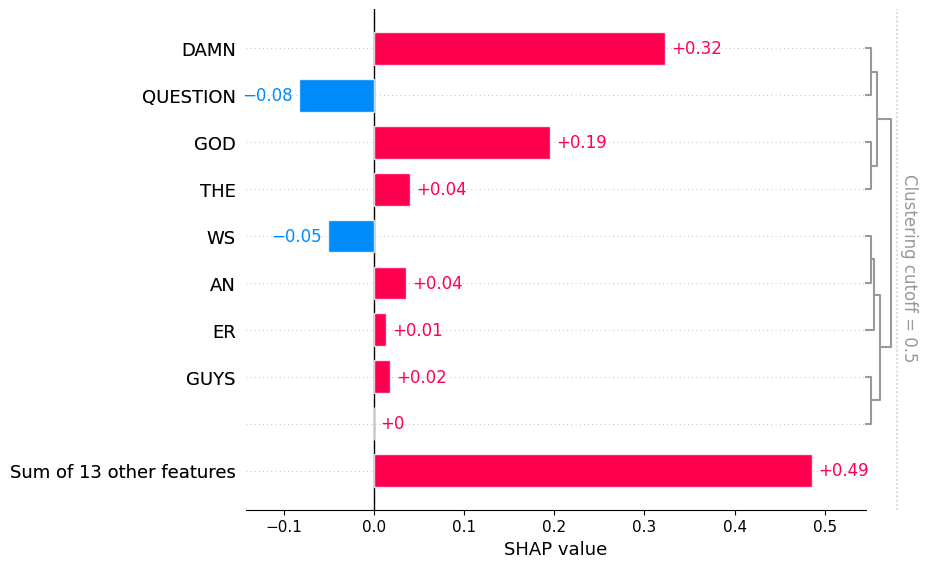

In [43]:
shap.plots.bar(shap_values[1,:,"LABEL_1"])

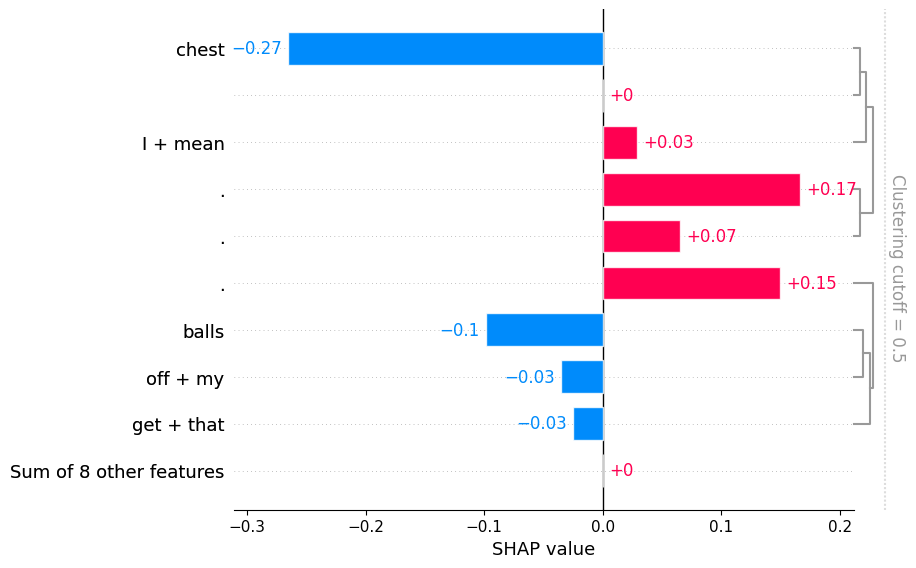

In [44]:
shap.plots.bar(shap_values[0,:,"LABEL_0"])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


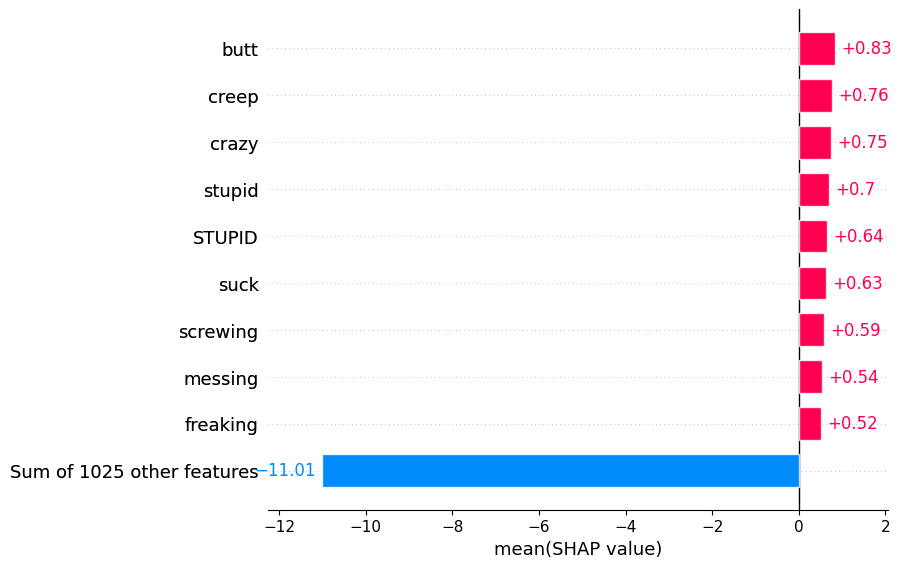

In [45]:
shap.plots.bar(shap_values[:, :, "LABEL_1"].mean(0))

In [48]:
# shap.plots.bar(shap_values[:, :, "LABEL_0"].mean(0))

In [49]:
# shap.plots.bar(shap_values[:, :, "LABEL_0"].mean(0), order=shap.Explanation.argsort)